Name: Mariam Fahs
ID: 202409257
Project name: Fake News Detector

This project will use a deep learning model that combines LSTM, CNN, and metadata features for fake news classification. The LSTM will capture the sequential structure of text, while the CNN will extract important n-gram features from the statements. In addition, metadata such as the speaker, context, and other relevant attributes will be incorporated into the model to provide a richer understanding of the data. Transfer learning with pretrained word embeddings (such as GloVe or Word2Vec) will be used to enhance the semantic understanding of the text.  

note: I wanted to create my own dataset and use the latest news but it needed to much time and resources, so maybe in the futur i will make a better version of this code with a new dataset.

I- Intializing libraries

In [478]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import tensorflow as tf 
from keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Input,Dense,Embedding,MaxPooling1D, LSTM,Conv1D, Dropout,Concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_score
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

II- Loading data


The LIAR dataset is a benchmark dataset form fake news detection consisting of 12,836 labeled short political statements collected from Politifact.com. each statement is accompanied by various metadata, providing context for more accrate classification.

In [411]:
splits = {'train': 'train.csv', 'validation': 'valid.csv', 'test': 'test.csv'}
df_train = pd.read_csv("hf://datasets/chengxuphd/liar2/" + splits["train"])
df_valid = pd.read_csv("hf://datasets/chengxuphd/liar2/" + splits["validation"])
df_test = pd.read_csv("hf://datasets/chengxuphd/liar2/" + splits["test"])
df_all = pd.concat([df_train, df_valid, df_test], ignore_index=True)

for the sake of simplicity ill will be droping the 6 columns that (true_count, mostly_count, ...) and there will be 2 values (0 and 1): (changing from categorical classification to binary classification)

0 -> false news

1 -> real news

In [ ]:
label_mapping={
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1
}

df_all['label'] = df_all['label'].map(label_mapping) 

III_ Some data visualizations

C:\Users\acer\AppData\Local\Temp\ipykernel_10648\4108745003.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df_all, palette="coolwarm",)


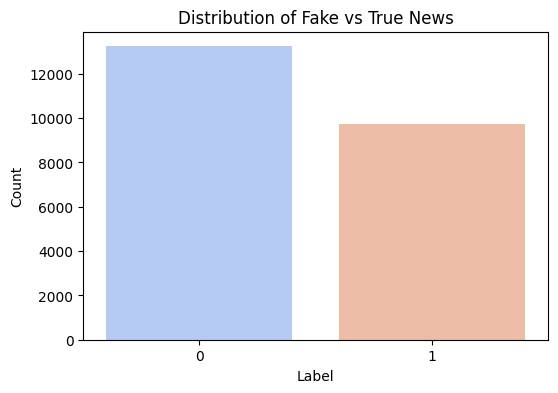

In [414]:
#Distribution of Labels 
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df_all, palette="coolwarm",)
plt.title("Distribution of Fake vs True News")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


IV- clean the data

In [420]:
df_all.dropna(inplace=True)

text preprocessing for the statement column

In [422]:
def clean_text(text):
    text=text.lower()
    text=re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    stop_words=set(stopwords.words('english'))
    text=' '.join(word for word in text.split() if word not in stop_words)
    return text
df_all['statement']=df_all['statement'].apply(clean_text)

tokanizing the 'statement column

In [ ]:
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")

In [457]:
tokenizer.fit_on_texts(df_all['statement']) 

In [462]:
X = tokenizer.texts_to_sequences(df_all['statement'])
X = pad_sequences(X, maxlen=500)

target label

In [463]:
y = df_all['label'].values

split the data into training and testing sets (75 by 25)

In [464]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [465]:
def read_embeddings():
    FILE_NAME = 'data/glove.6B.100d.txt'
    embeddings = {}
    file = open(FILE_NAME, 'r', encoding='utf-8')
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings[word] = vector
    file.close()
    print('Read %s embeddings.' % len(embeddings))
    return embeddings

In [466]:
vocab_size = 20000
embeddings_index = read_embeddings()
embedding_dim = 100 
embedding_matrix = np.zeros((vocab_size, embedding_dim))

Read 400000 embeddings.


In [467]:
for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

model architecture

In [468]:
#text processing model
input = Input(shape=(500,), name='text_input')
model=Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=500, weights=[embedding_matrix],trainable=True),
    Conv1D(filters=256, kernel_size=3,activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=False,kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5)
])(input) 



#final dense layers
output = Dense(64, activation='relu')(model)
BatchNormalization()
output = Dense(1, activation='sigmoid')(output)

#complete model
model = Model(inputs=input, outputs=output)

#compilnig the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_41 (Sequential)      │ (None, 64)             │     2,159,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,163,713 (8.25 MB)

 Trainable params: 2,163,585 (8.25 MB)

 Non-trainable params: 128 (512.00 B)

In [469]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.5389 - loss: 1.0307 - val_accuracy: 0.5345 - val_loss: 0.9329
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.5732 - loss: 0.9584 - val_accuracy: 0.5605 - val_loss: 0.9191
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.5931 - loss: 0.9280 - val_accuracy: 0.6017 - val_loss: 0.8989
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6077 - loss: 0.9000 - val_accuracy: 0.6095 - val_loss: 0.8843
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.6091 - loss: 0.8855 - val_accuracy: 0.6168 - val_loss: 0.8686
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.6249 - loss: 0.8618 - val_accuracy: 0.6156 - val_loss: 0.8619
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.6308 - loss: 0.8492 - val_accuracy: 0.6213 - val_loss: 0.8509
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.6386 - loss: 0.8340 - val_accu

In [474]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

133/133 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step


In [476]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1297  803]
 [ 781 1362]]


In [477]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62      2100
           1       0.63      0.64      0.63      2143

    accuracy                           0.63      4243
   macro avg       0.63      0.63      0.63      4243
weighted avg       0.63      0.63      0.63      4243



this is the best I could get with the time I had, although I think the accuracy will increase with more epochs

I searched a lot to see similar codes to improve the performance but all the samples I incountered included very complex models and even with thier complex models the accuracy never exceeded 75%, but I think if we multi-model it and use the numerical and the other features we can improve its performance. 